# Scale Detection
Train a model to detect the scale of an image relative to the scale of the training dataset for a model.

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

## Load the training data

Download data for nuclear, brightfield and fluorescent cytoplasm from `deepcell.datasets` and combine the data into a single training dataset.

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200514_IF_Training_8"
npz_name = "20200521_IF_Training_256"
npz_name = "20200810_all_data_normalized_scale_detection"

test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train_default, y_train_default = train_dict['X'], train_dict['y']
X_val_default, y_val_default = val_dict['X'], val_dict['y']

In [4]:
X_train, y_train = X_train_default[..., :1], y_train_default[..., :1]
X_val, y_val = X_val_default[..., :1], y_val_default[..., :1]

In [9]:
X_train, y_train = X_train_default[:, :216, :216, :], y_train_default[:, :216, :216, :]
X_val, y_val = X_val_default[:, :216, :216, :], y_val_default[:, :216, :216, :]

In [10]:
from deepcell_toolbox.processing import histogram_normalization
X_train, X_val = histogram_normalization(X_train, 128), histogram_normalization(X_val, 128)

## Create the Scale Detection Model

We are using the ScaleDetectionModel from `deepcell.applications`

In [56]:
from deepcell.applications import ScaleDetectionModel

# set use_pretrained_weights to False to retrain from scratch
model = ScaleDetectionModel(
    backbone='mobilenetv2',
    input_shape=X_train.shape[1:],
    use_pretrained_weights=False)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 216, 216, 2) 0                                            
__________________________________________________________________________________________________
image_normalization2d_2 (ImageN (None, 216, 216, 2)  0           input_3[0][0]                    
__________________________________________________________________________________________________
tensor_product_6 (TensorProduct (None, 216, 216, 3)  9           image_normalization2d_2[0][0]    
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 217, 217, 3)  0           tensor_product_6[0][0]           
____________________________________________________________________________________________

In [57]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 20
batch_size = 64
lr = 1e-3

optimizer = Adam(lr=lr, clipnorm=.001)
lr_sched = rate_scheduler(lr=lr, decay=0.9)

model.compile(optimizer, loss='mse', metrics=['mae', 'mape'])
MODEL_NAME = npz_name + '_scale_detection'
print(MODEL_NAME)

20200810_all_data_normalized_scale_detection_scale_detection


## Train the Model

Create the ImageDataGenerators and pass them to `model.fit_generator`.

In [58]:
from deepcell.image_generators import ScaleDataGenerator

# Create the image data generator for training

generator = ScaleDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=(0.25, 4),
    fill_mode='constant',
    cval=0
)

In [59]:
from tensorflow.python.keras import callbacks

model.fit_generator(
    generator.flow({'X': X_train, 'y': y_train}, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=generator.flow({'X': X_val, 'y': y_val}, batch_size=batch_size),
    validation_steps=X_val.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, MODEL_NAME + '.h5'),
            verbose=1,
            monitor='val_loss',
            save_best_only=True)
    ]
)

Epoch 1/20
76/77 [============================>.] - ETA: 0s - loss: 1.2360 - mean_absolute_error: 0.8680 - mean_absolute_percentage_error: 69.8609
Epoch 00001: val_loss improved from inf to 5.14738, saving model to /data/models/20200619_production_updates/20200810_all_data_normalized_scale_detection_scale_detection.h5
77/77 [==============================] - 81s 1s/step - loss: 1.2367 - mean_absolute_error: 0.8693 - mean_absolute_percentage_error: 70.4987 - val_loss: 5.1474 - val_mean_absolute_error: 2.0076 - val_mean_absolute_percentage_error: 95.9218
Epoch 2/20
76/77 [============================>.] - ETA: 0s - loss: 1.2518 - mean_absolute_error: 0.9600 - mean_absolute_percentage_error: 88.2657
Epoch 00002: val_loss improved from 5.14738 to 4.70222, saving model to /data/models/20200619_production_updates/20200810_all_data_normalized_scale_detection_scale_detection.h5
77/77 [==============================] - 22s 292ms/step - loss: 1.2534 - mean_absolute_error: 0.9609 - mean_absolute_

76/77 [============================>.] - ETA: 0s - loss: 1.1748 - mean_absolute_error: 0.9368 - mean_absolute_percentage_error: 88.8108
Epoch 00017: val_loss improved from 1.15842 to 1.15730, saving model to /data/models/20200619_production_updates/20200810_all_data_normalized_scale_detection_scale_detection.h5
77/77 [==============================] - 23s 303ms/step - loss: 1.1748 - mean_absolute_error: 0.9368 - mean_absolute_percentage_error: 88.8005 - val_loss: 1.1573 - val_mean_absolute_error: 0.9205 - val_mean_absolute_percentage_error: 90.7876
Epoch 18/20
76/77 [============================>.] - ETA: 0s - loss: 1.1833 - mean_absolute_error: 0.9368 - mean_absolute_percentage_error: 87.4060
Epoch 00018: val_loss improved from 1.15730 to 1.13034, saving model to /data/models/20200619_production_updates/20200810_all_data_normalized_scale_detection_scale_detection.h5
77/77 [==============================] - 23s 302ms/step - loss: 1.1814 - mean_absolute_error: 0.9356 - mean_absolute_per

## Run the model on test data

Run the model on validation data and visualize the performance.

In [60]:
model.load_weights(os.path.join(MODEL_DIR, MODEL_NAME + '.h5'))

test_data = generator.flow({'X': X_val, 'y': y_val}, batch_size=1)

true, pred = [], []
for i in range(1000):
    if i % 100 == 0:
        print(".", end="")

    X, y = test_data.next()
    true.append(y)
    pred.append(model.predict(X))
    
true = np.array(true)
pred = np.array(pred)

..........

Text(0, 0.5, 'Error')

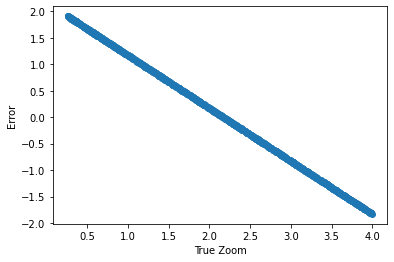

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(true, pred - true)
ax.set_xlabel('True Zoom')
ax.set_ylabel('Error')

[[2.1412358]] [[0.72566095]]


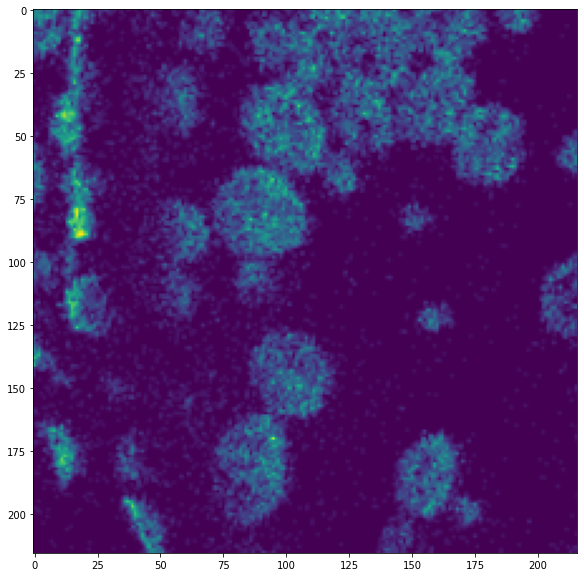

In [55]:
X, y = test_data.next()
from matplotlib import pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(X[0, :, :, 0].astype('float32'))
print(model.predict(X), y)

In [22]:
y_val.shape

(550, 216, 216, 1)